# Predicting Stock Prices Using Machine Learning

Article: https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

Code: https://github.com/YiLi225/NeptuneBlogs/blob/main/Predicting_StockPrices.py

## Data sources
Apple Stock: https://raw.githubusercontent.com/YiLi225/NeptuneBlogs/main/stock_market_data-AAPL.csv

## Create new neptune project

In [23]:
import config 
import os
os.environ['NEPTUNE_API_TOKEN'] = config.api_token

In [29]:
###### Create Neptune project 
## update: pip install neptune-client==0.9.8
import neptune
import os

# Connect your script to Neptune
project = neptune.init(api_token=os.getenv('NEPTUNE_API_TOKEN'),
                       project_qualified_name='slevin48/stockprices') 



## Log dummy data

In [1]:
import neptune.new as neptune

run = neptune.init(
    project="slevin48/stockprices",
    api_token=config.api_token,
)  # your credentials


https://app.neptune.ai/slevin48/stockprices/e/STOC-1
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
params = {"learning_rate": 0.001, "optimizer": "Adam"}
run["parameters"] = params

for epoch in range(10):
    run["train/loss"].log(0.9 ** epoch)

run["eval/f1_score"] = 0.66

run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.


All 14 operations synced, thanks for waiting!


## Import libs

In [2]:
###### Import all the packages for analysis
import pandas as pd
import numpy as np

# for reproducibility of our results
np.random.seed(42)

from datetime import date
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, Model
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

import tensorflow as tf 
tf.random.set_seed(42)

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json

In [9]:
# stock ticker symbol
ticker = 'AAPL' 

# Save data to this file
fileName = 'stock_market_data-%s.csv'%ticker

df = pd.read_csv("data/"+fileName,index_col="Unnamed: 0")
df

,Date,Low,High,Close,Open
5453,2021-07-06,140.070,143.15,142.02,140.07
5452,2021-07-02,137.745,140.00,139.96,137.90
5451,2021-07-01,135.760,137.33,137.27,136.60
5450,2021-06-30,135.870,137.41,136.96,136.17
5449,2021-06-29,134.350,136.49,136.33,134.80
...,...,...,...,...,...
4,1999-11-05,84.000,88.37,88.31,84.62
3,1999-11-04,80.620,85.37,83.62,82.06
2,1999-11-03,81.000,83.25,81.50,81.62
1,1999-11-02,77.310,81.69,80.25,78.00


In [10]:
   
# Sort DataFrame by date
stockprices = df.sort_values('Date')
stockprices

,Date,Low,High,Close,Open
0,1999-11-01,77.370,80.69,77.62,80.00
1,1999-11-02,77.310,81.69,80.25,78.00
2,1999-11-03,81.000,83.25,81.50,81.62
3,1999-11-04,80.620,85.37,83.62,82.06
4,1999-11-05,84.000,88.37,88.31,84.62
...,...,...,...,...,...
5449,2021-06-29,134.350,136.49,136.33,134.80
5450,2021-06-30,135.870,137.41,136.96,136.17
5451,2021-07-01,135.760,137.33,137.27,136.60
5452,2021-07-02,137.745,140.00,139.96,137.90


## Helper Functions

In [14]:

#### Define helper functions to calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

### The effectiveness of prediction method is measured in terms of the Mean Absolute Percentage Error (MAPE) and RMSE
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset 
        N - window size, e.g., 60 for 60 days 
        offset - position to start the split
    """
    X, y = [], []
    
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)


### For medium-term trading 
def plot_stock_trend(var, cur_title, stockprices=stockprices, logNeptune=True, logmodelName='Simple MA'):
    ax = stockprices[['Close', var,'200day']].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis('tight')
    plt.ylabel('Stock Price ($)')
    
    if logNeptune:
        npt_exp.log_image(f'Plot of Stock Predictions with {logmodelName}', ax.get_figure())
        
def calculate_perf_metrics(var, logNeptune=True, logmodelName='Simple MA'):
    ### RMSE 
    rmse = calculate_rmse(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:][var]))
    ### MAPE 
    mape = calculate_mape(np.array(stockprices[train_size:]['Close']), np.array(stockprices[train_size:][var]))
    
    if logNeptune:        
        npt_exp.send_metric('RMSE', rmse)
        npt_exp.log_metric('RMSE', rmse)
        
        npt_exp.send_metric('MAPE (%)', mape)
        npt_exp.log_metric('MAPE (%)', mape)
    
    return rmse, mape


In [12]:

#### Train-Test split for time-series ####
test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))

print("train_size: " + str(train_size))
print("test_size: " + str(test_size))

train = stockprices[:train_size][['Date', 'Close']]
test = stockprices[train_size:][['Date', 'Close']]

train_size: 4363
test_size: 1090


In [13]:

###================= simple MA
stockprices = stockprices.set_index('Date')
stockprices

,Low,High,Close,Open
Date,,,,
1999-11-01,77.370,80.69,77.62,80.00
1999-11-02,77.310,81.69,80.25,78.00
1999-11-03,81.000,83.25,81.50,81.62
1999-11-04,80.620,85.37,83.62,82.06
1999-11-05,84.000,88.37,88.31,84.62
...,...,...,...,...
2021-06-29,134.350,136.49,136.33,134.80
2021-06-30,135.870,137.41,136.96,136.17
2021-07-01,135.760,137.33,137.27,136.60


## Simple Moving Average

https://app.neptune.ai/slevin48/stockprices/e/STOC-2


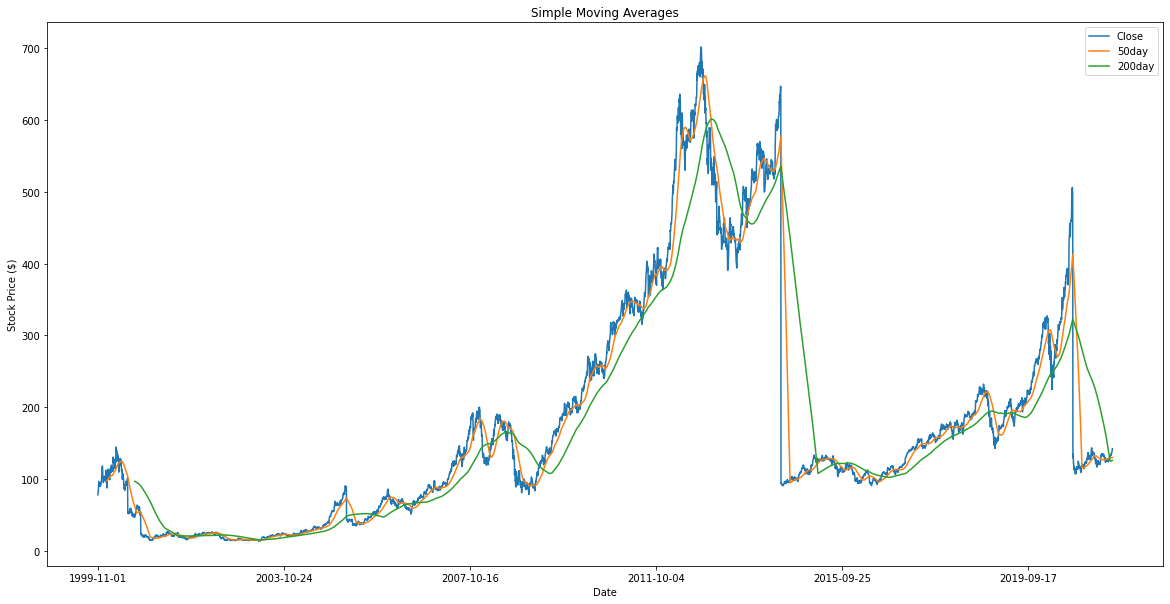

In [25]:
window_size = 50

# Create an experiment and log the model in Neptune new version
npt_exp = project.create_experiment(name='SMA', 
                                        description='stock-prediction-machine-learning', 
                                        tags=['stockprediction', 'MA_Simple', 'neptune'])



window_var = str(window_size) + 'day'
    
stockprices[window_var] = stockprices['Close'].rolling(window_size).mean()
### Include a 200-day SMA for reference 
stockprices['200day'] = stockprices['Close'].rolling(200).mean()
    
### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title='Simple Moving Averages', logmodelName='Simple MA')
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var, logmodelName='Simple MA')

### Stop the run after logging for new version
npt_exp.stop()

## Exponential Moving Average

https://app.neptune.ai/slevin48/stockprices/e/STOC-3


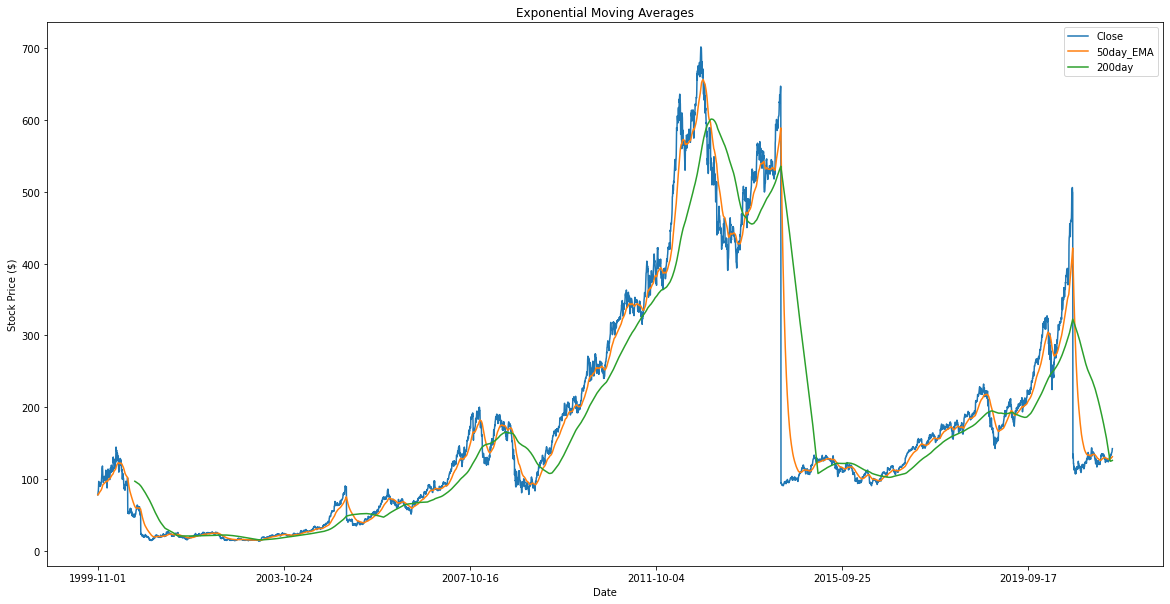

In [26]:
# Create an experiment and log the model in Neptune new version
npt_exp = project.create_experiment(name='EMA',                                         
                                    description='stock-prediction-machine-learning', 
                                    tags=['stockprediction', 'MA_Exponential', 'neptune'])
    
###### Exponential MA
window_ema_var = window_var+'_EMA'
# Calculate the 50-day exponentially weighted moving average
stockprices[window_ema_var] = stockprices['Close'].ewm(span=window_size, adjust=False).mean()
stockprices['200day'] = stockprices['Close'].rolling(200).mean()
    
### Plot and performance metrics for EMA model
plot_stock_trend(var=window_ema_var, cur_title='Exponential Moving Averages', logmodelName='Exp MA')
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var, logmodelName='Exp MA')
### Stop the run after logging for new version
npt_exp.stop()

## Predicting stock prices with an LSTM model

In [30]:
layer_units, optimizer = 50, 'adam' 
cur_epochs = 15
cur_batch_size = 20

cur_LSTM_pars = {'units': layer_units, 
                    'optimizer': optimizer, 
                    'batch_size': cur_batch_size, 
                    'epochs': cur_epochs
                    }
    
# Create an experiment and log the model in Neptune new version
npt_exp = project.create_experiment(name='LSTM', 
                                    params=cur_LSTM_pars, 
                                    description='stock-prediction-machine-learning', 
                                    tags=['stockprediction', 'LSTM','neptune'])

# npt_exp['LSTMPars'] = cur_LSTM_pars # new API calling convention

https://app.neptune.ai/slevin48/stockprices/e/STOC-5


In [31]:
# scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[['Close']])
scaled_data_train = scaled_data[:train.shape[0]]
    
# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)


In [33]:
### Build a LSTM model and log model summary to Neptune ###    
def Run_LSTM(X_train, layer_units=50, logNeptune=True, NeptuneProject=None):     
    inp = Input(shape=(X_train.shape[1], 1))
    
    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inp, out)
    
    # Compile the LSTM neural net
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    ## log to Neptune, e.g., set NeptuneProject = npt_exp 
    if logNeptune:
       model.summary(print_fn=lambda x: NeptuneProject.log_text('model_summary', x))
        
    return model   

model = Run_LSTM(X_train, layer_units=layer_units, logNeptune=True, NeptuneProject=npt_exp)

history = model.fit(X_train, y_train, epochs=cur_epochs, batch_size=cur_batch_size, 
                    verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/15
195/195 [==============================] - 17s 53ms/step - loss: 0.0522 - val_loss: 5.7623e-04
Epoch 2/15
195/195 [==============================] - 10s 49ms/step - loss: 0.0181 - val_loss: 6.3562e-04
Epoch 3/15
195/195 [==============================] - 9s 47ms/step - loss: 0.0124 - val_loss: 5.7105e-04
Epoch 4/15
195/195 [==============================] - 10s 50ms/step - loss: 0.0110 - val_loss: 0.0012
Epoch 5/15
195/195 [==============================] - 8s 43ms/step - loss: 0.0098 - val_loss: 4.2686e-04
Epoch 6/15
195/195 [==============================] - 9s 45ms/step - loss: 0.0077 - val_loss: 4.6668e-04
Epoch 7/15
195/195 [==============================] - 8s 42ms/step - loss: 0.0074 - val_loss: 3.4732e-04
Epoch 8/15
195/195 [==============================] - 10s 49ms/step - loss: 0.0062 - val_loss: 3.7115e-04
Epoch 9/15
195/195 [==============================] - 10s 52ms/step - loss: 0.0061 - val_loss: 3.5165e-04
Epoch 10/15
195/195 [==============================] -

In [36]:
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):    
    raw = data['Close'][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)
    
    X_test = []
    for i in range(window_size, raw.shape[0]):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price 
test['Predictions_lstm'] = predicted_price

d:\devel\stock\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [37]:
# Evaluate performance
rmse_lstm = calculate_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
mape_lstm = calculate_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))
npt_exp.send_metric('RMSE', rmse_lstm)
npt_exp.log_metric('RMSE', rmse_lstm)

npt_exp.send_metric('MAPE (%)', mape_lstm)
npt_exp.log_metric('MAPE (%)', mape_lstm)


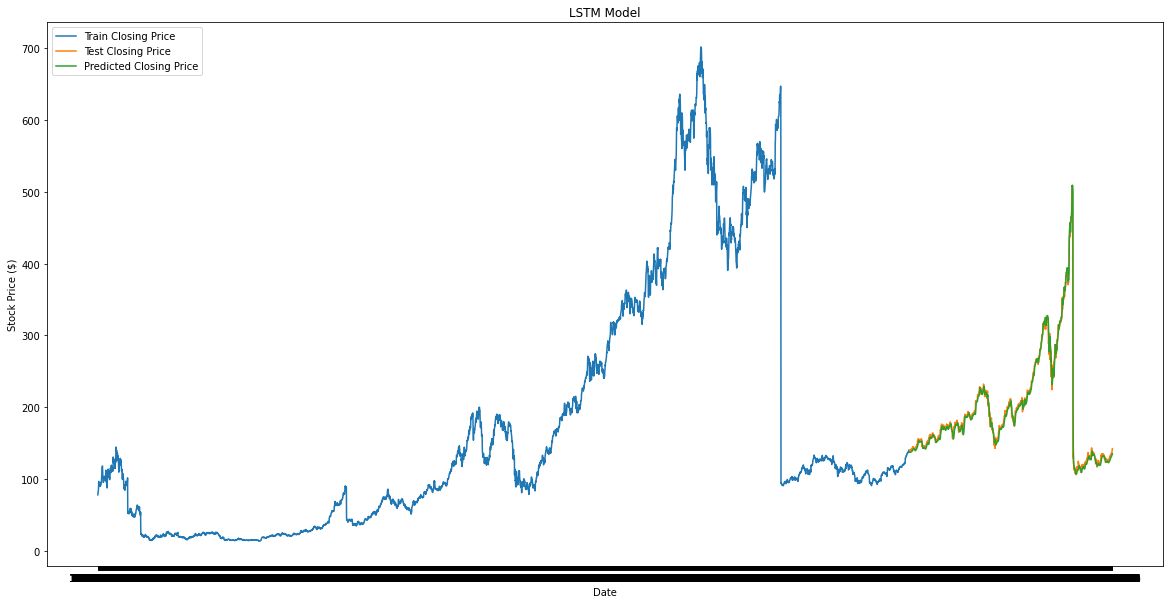

In [38]:
### Plot prediction and true trends and log to Neptune         
def plot_stock_trend_lstm(train, test, logNeptune=True):        
    fig = plt.figure(figsize = (20,10))
    plt.plot(train['Date'], train['Close'], label = 'Train Closing Price')
    plt.plot(test['Date'], test['Close'], label = 'Test Closing Price')
    plt.plot(test['Date'], test['Predictions_lstm'], label = 'Predicted Closing Price')
    plt.title('LSTM Model')
    plt.xlabel('Date')
    plt.ylabel('Stock Price ($)')
    plt.legend(loc="upper left")
    
    if logNeptune:
        npt_exp.log_image('Plot of Stock Predictions with LSTM', fig)
        
plot_stock_trend_lstm(train, test)

In [39]:
### Stop the run after logging for new version 
npt_exp.stop()